In [1]:
import numpy as np
from scipy.integrate import solve_ivp

import sympy as sp
from sympy.physics.mechanics import dynamicsymbols, init_vprinting

# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation

from qbstyles import mpl_style


mpl_style(dark=True)
init_vprinting()

<img src="two_body_sketch.jpg" alt="Two Body Sketch" width=300>

Newton's law of gravitation states that the gravitational force between two bodies is proportional to the product of their masses and inversely proportional to the square of the distance between them. Using vector calculus, we can write this as:

$$
\frac{d^2\vec{r}_i}{dt^2} = \sum_{j \neq i} \frac{G m_j}{\left| \vec{r}_{ij}\right|^3}\vec{r}_{ij}
$$

where $\vec{r}_i$ and $m_i$ are the position and mass of the $i \text{th}$ body, respectively. $\vec{r}_{ij} = \vec{r}_j - \vec{r}_i$ is the vector pointing from the $i \text{th}$ body to the $j \text{th}$ body. The gravitational constant $G$ is a universal constant that is the same for all bodies.

One problem is that the dimensions are gross, with the gravitational constant $G = 6.674 \times 10^{-11}$ being too small to efficiently compute. So we will non-dimensionalize our quantities and get an equation like this:

$$
\frac{d^2\vec{r'}_i}{dt'^2} = \sum_{j \neq i} \frac{m_j'}{\left| \vec{r'}_{ij}\right|^3}\vec{r'}_{ij}
$$

where:
* $\vec{r'}_i = \vec{r}_i / L$ where $L$ is some characteristic length in the system
* $m'_i = m_i / M$ where $M$ is some characteristic mass in the system
* $t' = t \sqrt{G M / L^3}$ where M and L are the characteristic mass and length

For the rest of this, we will drop the prime notation and assume that we are working with the non-dimensionalized quantities. After we solve our ODEs in terms of the dimensionless $t'$, we can convert back to the dimensional $t$ by using:

$$
t = t' \sqrt{\frac{L^3}{G M}}
$$

The two-body problem I will be considering is the Alpha Centauri AB system. While Alpha Centauri is a triple star system, the third star Proxima Centauri is much less massive than the other two so we will just consider the binary star system and the force of gravity on it. Therefore, we will set our characteristic quantities:

* $L = 3.441 \times 10^{12} \text{ m}$ (distance between Alpha Centauri A and B)
* $M = 1.989 \times 10^{30} \text{ kg}$ (mass of Sun)

Now we may simulate the motion of the Alpha Centauri AB system. Alpha Centauri A will be mass 1 and B will be mass 2.

In [417]:
class TwoBodyProblem:
    def __init__(self, m1, m2, r0, v0, nd):
        self.m1 = m1 # mass of the first body
        self.m2 = m2 # mass of the second body
        self.r0 = r0 # initial position
        self.v0 = v0 # initial velocity
        
        self.nd = nd # non-dimensionalization factors
        self.G = self.nd['G'] # gravitational constant
        self.M = self.nd['M'] # characteristic mass
        self.L = self.nd['L'] # characteristic length
        
    
    def S_dot(self, t, S):
        x1, y1, z1, x2, y2, z2, vx1, vy1, vz1, vx2, vy2, vz2 = S
        r = np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
        return [
            vx1,
            vy1,
            vz1,
            vx2,
            vy2,
            vz2,
            self.m2/r**3 * (x2 - x1),
            self.m2/r**3 * (y2 - y1),
            self.m2/r**3 * (z2 - z1),
            self.m1/r**3 * (x1 - x2),
            self.m1/r**3 * (y1 - y2),
            self.m1/r**3 * (z1 - z2)
        ]
    
    def solve(self, t_span, t_eval):
        
        S_0 = np.concatenate([self.r0, self.v0]).flatten()
        
        sol = solve_ivp(
            fun=self.S_dot,
            t_span=t_span,
            y0=S_0,
            t_eval=t_eval
        )
    
        self.x1_array, self.y1_array, self.z1_array, self.x2_array, self.y2_array, self.z2_array, self.vx1_array, self.vy1_array, self.vz1_array, self.vx2_array, self.vy2_array, self.vz2_array = sol.y
        self.time = sol.t
    
    def save_sol(self, filename):
        np.savetxt(
        filename,
        np.transpose([self.time, self.x1_array, self.x2_array, self.y1_array, self.y2_array, self.z1_array, self.z2_array, self.vx1_array, self.vx2_array, self.vy1_array, self.vy2_array, self.vz1_array, self.vz2_array]),
        delimiter=",", 
        header="time,x1,x2,y1,y2,z1,z2,vx1,vx2,vy1,vy2,vz1,vz2",
        )
    
        
    def plot_data(self, filename, labels):
        title = labels['datatitle']
        body1 = labels['body1']
        body2 = labels['body2']
        
        
        # have 6 subplots in a 2x3 grid
        fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
        # get rid of axis with index 0
        fig.axes[0].remove()


        ax1.plot(self.x1_array, color="tab:purple")
        ax1.plot(self.x2_array, color="tab:red")
        ax1.set_xlabel("time")
        ax1.set_ylabel("$x$")
        ax1.set_title("$x$ vs time")
        ax1.legend([body1, body2])


        ax2.plot(self.y1_array, color="tab:purple")
        ax2.plot(self.y2_array, color="tab:red")
        ax2.set_xlabel("time")
        ax2.set_ylabel(r"$y$")
        ax2.set_title(r"$y$ vs time")
        ax2.legend([body1, body2])


        ax3.plot(self.z1_array, color="tab:purple")
        ax3.plot(self.z2_array, color="tab:red")
        ax3.set_xlabel("time")
        ax3.set_ylabel(r"$z$")
        ax3.set_title(r"$z$ vs time")
        ax3.legend([body1, body2])


        ax4.plot(self.vx1_array, color="tab:pink")
        ax4.plot(self.vx2_array, color="tab:orange")
        ax4.set_xlabel("time")
        ax4.set_ylabel(r"$v_x$")
        ax4.set_title(r"$v_x$ vs time")
        ax4.legend([body1, body2])
        

        ax5.plot(self.vy1_array, color="tab:pink")
        ax5.plot(self.vy2_array, color="tab:orange")
        ax5.set_xlabel("time")
        ax5.set_ylabel(r"$v_y$")
        ax5.set_title(r"$v_y$ vs time")
        ax5.legend([body1, body2])


        ax6.plot(self.vz1_array, color="tab:pink")
        ax6.plot(self.vz2_array, color="tab:orange")
        ax6.set_xlabel("time")
        ax6.set_ylabel(r"$v_z$")
        ax6.set_title(r"$v_z$ vs time")
        ax6.legend([body1, body2])
        
        
        fig.suptitle(title, fontsize=16)
        fig.tight_layout()
        
        plt.savefig(filename, dpi=300)
        
        
    
    def animate_system(self, n, filename, labels):
        title = labels['anititle']
        body1 = labels['body1']
        body2 = labels['body2']
        
        
        # Convert time to seconds
        scale_factor = 1/np.sqrt(self.G * self.M / self.L**3)

        self.ctime = self.time * scale_factor
        
        
        # To make the animation take less time, get every nth element
        self.ani_x1_array = self.x1_array[::n]
        self.ani_y1_array = self.y1_array[::n]
        self.ani_z1_array = self.z1_array[::n]
        self.ani_x2_array = self.x2_array[::n]
        self.ani_y2_array = self.y2_array[::n]
        self.ani_z2_array = self.z2_array[::n]

        self.ani_time = self.time[::n]
        
        
        # Animation
        def animate(i):
            point1.set_data(self.ani_x1_array[i], self.ani_y1_array[i])
            point1.set_3d_properties(self.ani_z1_array[i])

            point2.set_data(self.ani_x2_array[i], self.ani_y2_array[i])
            point2.set_3d_properties(self.ani_z2_array[i])
            
            line1.set_data(self.ani_x1_array[:i], self.ani_y1_array[:i])
            line1.set_3d_properties(self.ani_z1_array[:i])
            
            line2.set_data(self.ani_x2_array[:i], self.ani_y2_array[:i])
            line2.set_3d_properties(self.ani_z2_array[:i])

        fig = plt.figure(figsize=(8, 8))
        fig.delaxes(fig.axes[0])
        ax = fig.add_subplot(111, projection='3d')
        ax.dist = 11

        point1, = ax.plot([], [], [], 'o', color='tab:purple', markersize=10, label=body1)
        point2, = ax.plot([], [], [], 'o', color='tab:red', markersize=10, label=body2)

        line1, = ax.plot([], [], [], color='tab:purple', linewidth=1)
        line2, = ax.plot([], [], [], color='tab:red', linewidth=1)


        # Make the background panes # 0C1C23
        ax.w_xaxis.set_pane_color((12/255, 28/255, 35/255, 1.0))
        ax.w_yaxis.set_pane_color((12/255, 28/255, 35/255, 1.0))
        ax.w_zaxis.set_pane_color((12/255, 28/255, 35/255, 1.0))

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')

        ax.set_xlim(1.5 * np.min(np.concatenate((self.x1_array, self.x2_array))), 1.5 * np.max(np.concatenate((self.x1_array, self.x2_array))))
        ax.set_ylim(1.5 * np.min(np.concatenate((self.y1_array, self.y2_array))), 1.5 * np.max(np.concatenate((self.y1_array, self.y2_array))))
        ax.set_zlim(1.5 * np.min(np.concatenate((self.z1_array, self.z2_array))), 1.5 * np.max(np.concatenate((self.z1_array, self.z2_array))))
            
        ax.legend(loc='upper right')
        ax.set_title(title)


        ani = animation.FuncAnimation(fig, animate, frames=len(self.ani_time), interval=1, blit=False, repeat=False)
        ani.save(filename, writer='pillow', fps=30)
            

In [463]:
param_G = 6.67408e-11 # gravitational constant
param_M = 1.989e30 # mass of the sun
param_L = 1.496e11 # 1 AU
param_nd = {'G': param_G, 'M': param_M, 'L': param_L}


param_m1 = 1.1 # mass of body 1
param_m2 = 0.9 # mass of body 2


r0 = np.array([-0.5, 0.0, 0.0, 0.5, 0.0, 0.0])

v0 = np.array([0.5, 0.5, 0.5, -0.5, -0.5, -0.5])

In [464]:
alpha_centauri = TwoBodyProblem(param_m1, param_m2, r0, v0, param_nd)

In [465]:
t_0 = 0.0 # initial time
t_f = 150.0 # final time
time_frame = [t_0, t_f]
t_eval = np.linspace(t_0, t_f, 10000)


alpha_centauri.solve(t_span=time_frame, t_eval=t_eval)

alpha_centauri.save_sol("two_body_problem.csv")

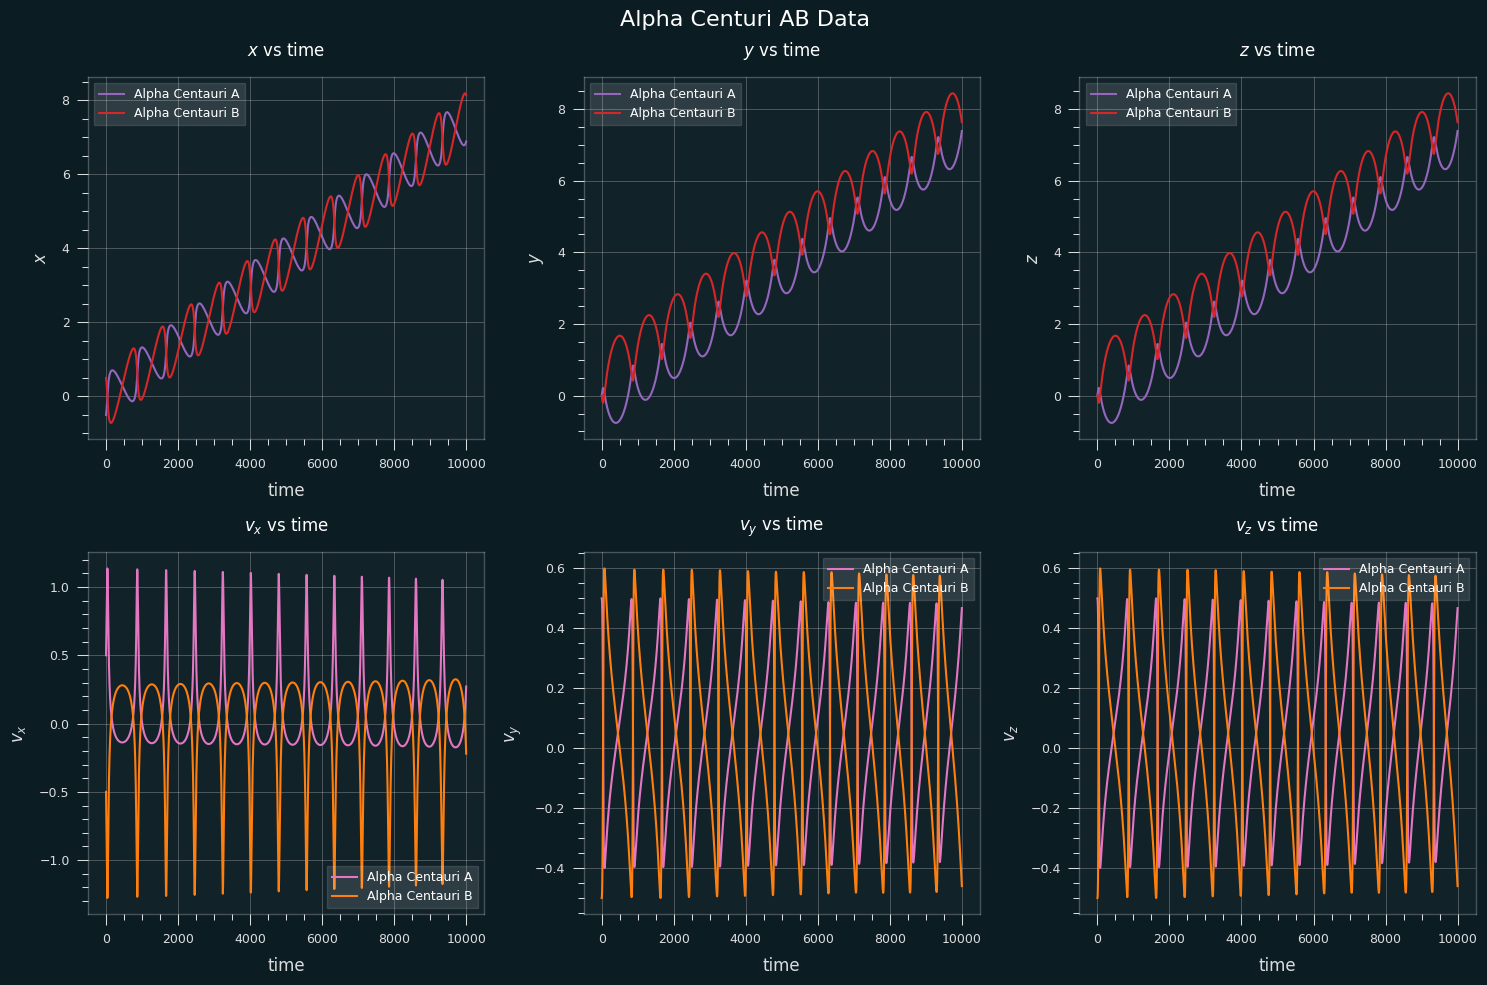

In [466]:
labels = {'datatitle': "Alpha Centuri AB Data", 'anititle': "Alpha Centuri AB", 'body1': "Alpha Centauri A", 'body2': "Alpha Centauri B"}

alpha_centauri.plot_data('Figures/alpha_centauri_data.png', labels)

C:\Users\Owner\AppData\Local\Temp\ipykernel_9500\745441836.py:162: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11
C:\Users\Owner\AppData\Local\Temp\ipykernel_9500\745441836.py:172: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((12/255, 28/255, 35/255, 1.0))
C:\Users\Owner\AppData\Local\Temp\ipykernel_9500\745441836.py:173: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((12/255, 28/255, 35/255, 1.0))
C:\Users\Owner\AppData\Local\Temp\ipykernel_9500\745441836.py:174: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((12/255, 28/255, 35/255, 1.0))
C:\Users\Owner\A

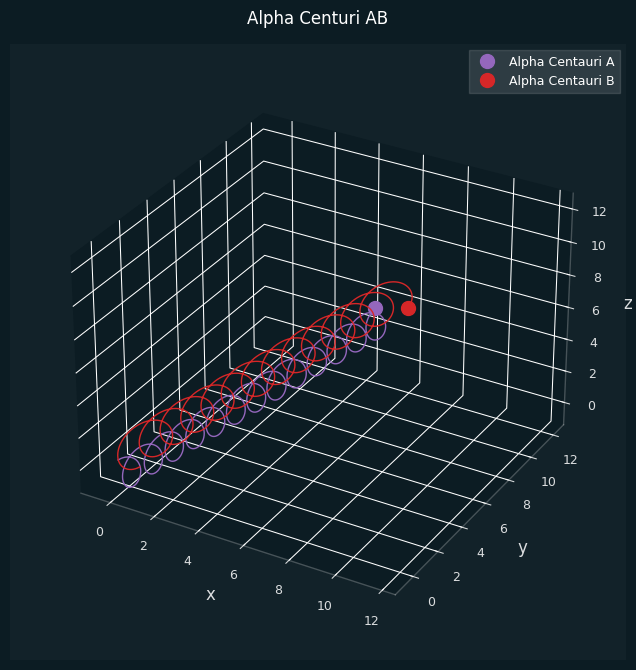

In [467]:
alpha_centauri.animate_system(5, 'Animations/two_body_problem.gif', labels)